# Paper Plots and Radio-Loudness

In [1]:
import csv
import numpy as np
from lifelines import KaplanMeierFitter

from scipy.constants import c
from scipy.special import erf, erfinv

from astropy.table import QTable
from astropy.io import fits

import matplotlib.pyplot as plt

In [2]:
# define a cosmology
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
print(cosmo.H0, cosmo.Tcmb, cosmo.Om0)

#from astropy.cosmology import FlatLambdaCDM
#cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

67.66 km / (Mpc s) <bound method FLRW.Tcmb of FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)> 0.30966


## Load Data

In [3]:
with open('../tables/table2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    data = np.array([row for row in reader]).T

obsnames = data[0]
z_list, freq, fluxpeaks, fluxpeaks_err, ul_list, m1450_list, allwise_AB_list, allwise_err_list, spitzer_AB_list, spitzer_AB_err_list, Lsgn, log_L_nu_list, log_L_peak_list, log_L_peak_err_list, log_L_ul_list, log_L4400_list, log_L4400_err_list, R_list, Rerr_list, Rul_list = data[1:].astype(float)

print(f"median redshift: z={np.median(z_list)}")

median redshift: z=6.15


In [4]:
qso_catalog = QTable.read('../tables/Quasar_catalog_Banados+16_Matsuoka+19a_Matsuoka+19b_Wang+18_Wang+19_Reed+19_Yang+20.txt', format='ascii')

ref_list = []
bmin_list = []
bmax_list = []

for obsname in obsnames:
    imfits = f"/rds/user/pmk46/hpc-work/19A-056/final/images/{obsname}-res.im-MFS-image.fits"

    obsname = list(obsname)
    obsname[3] = "_"
    obsname = "".join(obsname)

    ref_list.append(qso_catalog["Ref"][qso_catalog["QSO-Name"] == obsname].value[0])

    hdu = fits.open(imfits)[0]
    bmin_list.append(hdu.header["BMIN"])
    bmax_list.append(hdu.header["BMAJ"])

ref_list = np.array(ref_list)


## Load AK's table. These results were obtained using CASA's wprojection algorithm.

In [5]:
with open('../tables/ajay.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    data = np.array([row for row in reader]).T

ajaynames = data[0]
ajay_fluxpeaks_err, ajay_fluxpeaks = data[1:].astype(float)

E = erf(ajay_fluxpeaks / ajay_fluxpeaks_err / np.sqrt(2))
ajay_ul_list = ajay_fluxpeaks_err * np.sqrt(2) * (erfinv(1 - (1 + E) * 0.002699796) + ajay_fluxpeaks / ajay_fluxpeaks_err / np.sqrt(2))

## Plot AK's vs PK's results
The lower flux densities obtained by PK are likely due to the deeper CLEANing and subtraction of outliere in the first side-lobe. Note that there are some marginal detections, which are not detected by both.

In [6]:
i_det, i_ul = [], []

for i, (fp, fperr) in enumerate(zip(fluxpeaks, fluxpeaks_err)):
    if fp/fperr > 3:
        i_det.append(i)
    else:
        i_ul.append(i)

In [7]:
det_names = ["QSO-J0100+2802", "QSO-J0818+1722", "QSO-J1034-1425", "QSO-J1427+3312", "QSO-J1429+5447", "QSO-J1558-0724", "QSO-J1602+4228", "QSO-J2318-3113"]
#det_names = ["QSO-J0100+2802", "QSO-J1034-1425", "QSO-J1427+3312", "QSO-J1429+5447", "QSO-J1558-0724", "QSO-J2318-3113"]

i_det = np.where(np.in1d(obsnames, det_names))
i_ul = np.where(~np.in1d(obsnames, det_names))
i_ul_1 = np.intersect1d(i_ul, np.where(ref_list == "Banados+16")[0])
i_ul_2 = np.intersect1d(i_ul, np.where(ref_list == "Matsuoka+19b")[0])

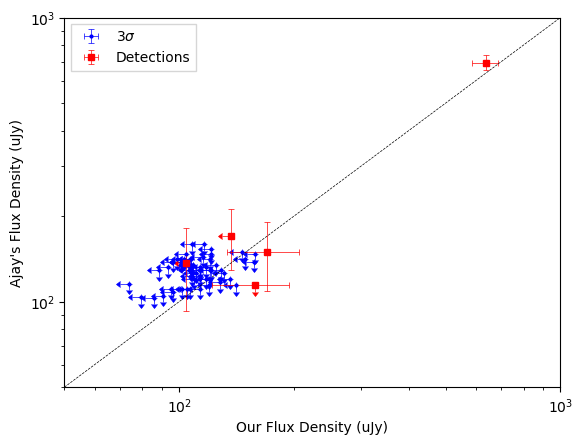

In [8]:
x_flux = []
y_flux = []
x_fluxerr = []
y_fluxerr = []
x_fluxtype = []
y_fluxtype = []

for i, name in enumerate(ajaynames):
    if name in obsnames:
        j = np.where(obsnames == name)[0][0]

        if j in i_det[0]:
            x_flux.append(fluxpeaks[j])
            x_fluxerr.append(fluxpeaks_err[j])
            x_fluxtype.append(False)
        else:
            x_flux.append(3*fluxpeaks_err[j])
            x_fluxerr.append(0.05 * 3*fluxpeaks_err[j])
            x_fluxtype.append(True)
        if ajay_fluxpeaks[i] != 0:
            y_flux.append(ajay_fluxpeaks[i])
            y_fluxerr.append(ajay_fluxpeaks_err[i])
            y_fluxtype.append(False)
        else:
            y_flux.append(3 * ajay_fluxpeaks_err[i])
            y_fluxerr.append(0.05 * 3 * ajay_fluxpeaks_err[i])
            y_fluxtype.append(True)

x_flux = np.array(x_flux)
y_flux = np.array(y_flux)
x_fluxerr = np.array(x_fluxerr)
y_fluxerr = np.array(y_fluxerr)
x_fluxtype = np.array(x_fluxtype)
y_fluxtype = np.array(y_fluxtype)

idx_det = np.where((~x_fluxtype) | (~y_fluxtype))[0]
idx_ul = np.where(~((~x_fluxtype) | (~y_fluxtype)))[0]

plt.errorbar(x_flux[idx_ul], y_flux[idx_ul], xerr=x_fluxerr[idx_ul], yerr=y_fluxerr[idx_ul], uplims=y_fluxtype[idx_ul], xuplims=x_fluxtype[idx_ul], fmt=".", color="b", capsize=2, capthick=.5, elinewidth=.5, ms=4, label=r"$3\sigma$")
plt.errorbar(x_flux[idx_det], y_flux[idx_det], xerr=x_fluxerr[idx_det], yerr=y_fluxerr[idx_det], uplims=y_fluxtype[idx_det], xuplims=x_fluxtype[idx_det], fmt="s", color="r", capsize=2, capthick=.5, elinewidth=.5, ms=4, label=r"Detections")

plt.plot([50, 1000], [50, 1000], c="k", linestyle="--", linewidth=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlim(50, 1000)
plt.ylim(50, 1000)
plt.xlabel("Our Flux Density (uJy)")
plt.ylabel("Ajay's Flux Density (uJy)")
plt.legend(fancybox=False)
plt.minorticks_on()

## Plot Radio Luminosity vs Optical Luminosity and Indicate Radio-Loud and Radio-Quiet Regions

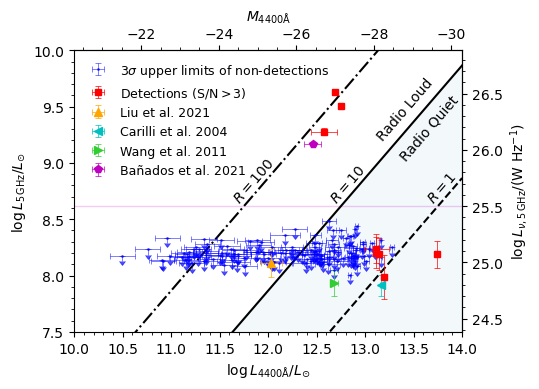

In [9]:
fig, ax1 = plt.subplots(figsize=(5.5, 4))

Lsol = 3.828e26
LtoLd = lambda x: x - np.log10(5e9 / Lsol)
LdtoL = lambda x: x + np.log10(5e9 / Lsol)

LtoM = lambda x: -2.5 * (x + np.log10(Lsol * 4.4e-7 / c)) + 34.1
MtoL = lambda x: (34.1 - (x - np.log10(Lsol * 4.4e-7 / c))) / 2.5

r1 = lambda x: (x + np.log10(4.4e-7 / c)) + np.log10(5e9)
r10 = lambda x: 1 + (x + np.log10(4.4e-7 / c)) + np.log10(5e9)
r100 = lambda x: 2 + (x + np.log10(4.4e-7 / c)) + np.log10(5e9)

x = np.linspace(10, 14, 100)

ax1.hlines(LdtoL(25.5), 10, 14, linewidth=1, alpha=0.2, color="m")
ax1.plot(x, r1(x), c="k", linestyle="--")
ax1.plot(x, r10(x), c="k", linestyle="-")
ax1.plot(x, r100(x), c="k", linestyle="-.")
ax1.fill_between(x, r10(x), alpha=0.05)

ax1.errorbar(log_L4400_list[i_ul_1], log_L_ul_list[i_ul_1], xerr=log_L4400_err_list[i_ul_1], yerr=0.05, fmt='.', color="b", capsize=2, capthick=.5, elinewidth=.5, ms=2, uplims=True, label=r"3$\sigma$ upper limits of non-detections", alpha=0.7)
ax1.errorbar(log_L4400_list[i_ul_2], log_L_ul_list[i_ul_2], xerr=log_L4400_err_list[i_ul_2], yerr=0.05, fmt='.', color="b", capsize=2, capthick=.5, elinewidth=.5, ms=2, uplims=True, alpha=0.7)
ax1.errorbar(log_L4400_list[i_det], log_L_peak_list[i_det], xerr=log_L4400_err_list[i_det], yerr=log_L_peak_err_list[i_det], fmt='s', color="r", capsize=2, capthick=.5, elinewidth=.5, ms=4, label=r"Detections ($\mathrm{S/N}>3$)")

# add literature values
i_lit_1 = np.where(obsnames == "QSO-J0227-0605")[0][0]
i_lit_2 = np.where(obsnames == "QSO-J1148+5251")[0][0]
i_lit_3 = np.where(obsnames == "QSO-J1319+0950")[0][0]

alpha = -0.75

log_L_peak_1 = np.log10(13 * 1e7)
log_L_peak_1_err = 1.6 / 13
ax1.errorbar(np.log10(10.8e11), log_L_peak_1, xerr=log_L4400_err_list[i_lit_1], yerr=log_L_peak_1_err, fmt='^', color="orange", capsize=2, capthick=.5, elinewidth=.5, ms=6, label=r"Liu et al. 2021")

z = z_list[i_lit_2]
dl = cosmo.luminosity_distance(z).to("m").value
log_L_peak_2 = np.log10(4 * np.pi * dl**2 * 1e-26 * (5 / (1.4 * (1+z)))**alpha * np.abs(55) / (1+z) / 1e6 * 5e9 / Lsol)
log_L_peak_2_err = 12 / 55 / np.log(10)
ax1.errorbar(log_L4400_list[i_lit_2], log_L_peak_2, xerr=log_L4400_err_list[i_lit_2], yerr=log_L_peak_2_err, fmt='<', color="c", capsize=2, capthick=.5, elinewidth=.5, ms=6, label=r"Carilli et al. 2004")

z = z_list[i_lit_3]
dl = cosmo.luminosity_distance(z).to("m").value
log_L_peak_2 = np.log10(4 * np.pi * dl**2 * 1e-26 * (5 / (1.4 * (1+z)))**alpha * np.abs(64) / (1+z) / 1e6 * 5e9 / Lsol)
log_L_peak_2_err = 17 / 64 / np.log(10)
ax1.errorbar(log_L4400_list[i_lit_3], log_L_peak_2, xerr=log_L4400_err_list[i_lit_3], yerr=log_L_peak_2_err, fmt='>', color="limegreen", capsize=2, capthick=.5, elinewidth=.5, ms=6, label=r"Wang et al. 2011")

z = 6.82
dl = cosmo.luminosity_distance(z).to("m").value
log_L_peak_2 = np.log10(4 * np.pi * dl**2 * 1e-26 * (5 / (1.52 * (1+z)))**(-1.31) * np.abs(510) / (1+z) / 1e6 * 5e9 / Lsol)
log_L_peak_2_err = 15 / 510 / np.log(10)
ax1.errorbar(np.log10(1.1 * 1e46 / 1e7 / Lsol), log_L_peak_2, xerr=0.1/1.1, yerr=log_L_peak_2_err, fmt='p', color="m", capsize=2, capthick=.5, elinewidth=.5, ms=6, label=r"Bañados et al. 2021")

ax2 = ax1.secondary_yaxis("right", functions=(LtoLd, LdtoL))
ax3 = ax1.secondary_xaxis("top", functions=(LtoM, MtoL))

ax1.set_xlabel(r"$\log{L_{4400\mathrm{\AA}}} / L_{\odot}$")
ax1.set_ylabel(r"$\log{L_{5\,\mathrm{GHz}}} / L_{\odot}$")
ax2.set_ylabel(r"$\log{L_{\nu,5\,\mathrm{GHz}}} / (\mathrm{W~Hz}^{-1})$")
ax3.set_xlabel(r"$M_{4400\mathrm{\AA}}$")

ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

plt.text(11.62, 8.65, r"$R=100$", rotation=45, transform_rotates_text=True)
plt.text(12.62, 8.65, r"$R=10$", rotation=45, transform_rotates_text=True)
plt.text(13.62, 8.65, r"$R=1$", rotation=45, transform_rotates_text=True)
plt.text(13.1, 9.2, "Radio Loud", rotation=45, transform_rotates_text=True)
plt.text(13.33, 9.03, "Radio Quiet", rotation=45, transform_rotates_text=True)

plt.xlim([10, 14])
plt.ylim([7.5, 10])
plt.legend(loc=2, fancybox=False, frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig("../../plots/R_plot.pdf", dpi=600)

In [10]:
print(f"number of RQ upper limits: {np.sum(Rul_list < 10)},", f"number of upper limits in RL region: {np.sum(Rul_list >= 10)},")

number of RQ upper limits: 71, number of upper limits in RL region: 67,


## Plot the Cummulative Density of the Radio-Loudness Parameter

### Load Data

In [11]:
with open('../tables/table2.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    data = np.array([row for row in reader]).T

obsnames = data[0].copy()
obsnames = np.hstack([obsnames[i_det], obsnames[i_ul]])
z = np.hstack([z_list[i_det], z_list[i_ul]])
log_L4400 = np.hstack([log_L4400_list[i_det], log_L4400_list[i_ul]])

### This Catalogue with Quasars from the Literature

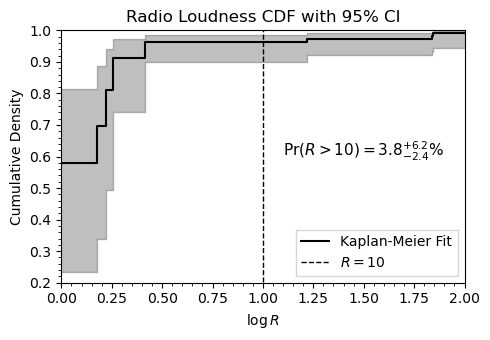

In [12]:

logR = np.log10(np.hstack([R_list[i_det], Rul_list[i_ul]]))
obsnames = data[0].copy()
obsnames = np.hstack([obsnames[i_det], obsnames[i_ul]])

E = np.zeros_like(logR)
E[:len(i_det[0])] = 1

# add a literature values
idx = np.where(obsnames == "QSO-J1148+5251")[0][0]
logR[idx] = np.log10(0.7)
E[idx] = 1

idx = np.where(obsnames == "QSO-J0227-0605")[0][0]
logR[idx] = np.log10(16.5)
E[idx] = 1

idx = np.where(obsnames == "QSO-J1319+0950")[0][0]
logR[idx] = np.log10(2.6)
E[idx] = 1

# add PSO J172.3556+18.7734
logR = np.append(logR, np.log10(70))
E = np.append(E, 1)
obsnames = np.append(obsnames, "PSO J172.3556+18.7734")

# remove radio-selected source
idx = np.where(obsnames == "QSO-J1427+3312")[0][0]
logR = np.delete(logR, idx)
obsnames = np.delete(obsnames, idx)
E = np.delete(E, idx)

kmf = KaplanMeierFitter()
res = kmf.fit_left_censoring(logR, E)

idx = np.argmin(np.abs(kmf.cumulative_density_['KM_estimate'].index - 1.0))
km, kml, kmu = (kmf.cumulative_density_['KM_estimate'].values[idx], kmf.confidence_interval_cumulative_density_['KM_estimate_lower_0.95'].values[idx], kmf.confidence_interval_cumulative_density_['KM_estimate_upper_0.95'].values[idx])

rlf = (1 - km) * 100
rlfu = np.abs(km - kml) * 100
rlfl = np.abs(km - kmu) * 100

fig = plt.figure(figsize=(5, 3.5))
kmf.plot_cumulative_density(label="Kaplan-Meier Fit", color="k", xlabel=r"$\log{R}$", ylabel=r"Cumulative Density")
plt.vlines(1, 0, 1, linestyle="--", color="k", linewidth=1, label=r"$R=10$")
plt.xlim([0.0, 2.0])
plt.ylim([0.2, 1.0])
plt.minorticks_on()
plt.title("Radio Loudness CDF with 95% CI")
plt.legend(fancybox=False, loc=4)
plt.text(1.1, 0.6, r"$\mathrm{Pr}(R>10)={%.1f}^{+%.1f}_{-%.1f} %s$" % (rlf.round(1), rlfu.round(1), rlfl.round(1), "\%"), fontsize=11)
plt.tight_layout()
plt.savefig("../../plots/kmr.pdf")

In [13]:
print(f"Radio Loud Fraction: RLF = {rlf.round(1)} (+{rlfu.round(1)}, -{rlfl.round(1)})")

Radio Loud Fraction: RLF = 3.8 (+6.2, -2.4)


### Plot Cummulative Density of log(R) fot Bañados+16 Quasars

Text(1.25, 0.6, '$P(R>10)={3.3}^{+6.6}_{-2.2} \\%$')

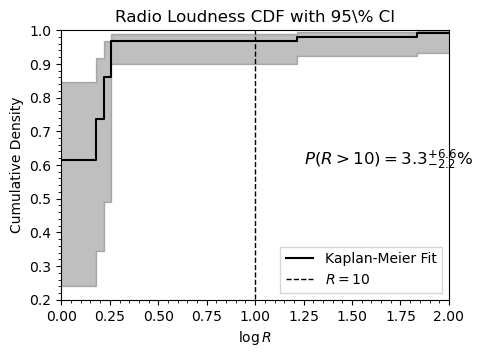

In [14]:
i1 = np.where((ref_list[i_det] == 'Banados+16'))[0]
i2 = np.where((ref_list[i_ul] == 'Banados+16'))[0]

logR = np.log10(np.hstack([R_list[i_det][i1], Rul_list[i_ul][i2]]))
E = np.zeros_like(logR)
E[:len(i1)] = 1

obsnames = data[0]
obsnames = np.hstack([obsnames[i_det][i1], obsnames[i_ul][i2]])

# add literature values
try:
    idx = np.where(obsnames == "QSO-J1148+5251")[0][0]
    logR[idx] = np.log10(0.7)
    E[idx] = 1
except:
    pass

try:
    idx = np.where(obsnames == "QSO-J0227-0605")[0][0]
    logR[idx] = np.log10(16.5)
    E[idx] = 1
except:
    pass

# remove radio-selected source
try:
    idx = np.where(obsnames == "QSO-J1427+3312")[0][0]
    logR = np.delete(logR, idx)
    E = np.delete(E, idx)
except:
    pass

kmf = KaplanMeierFitter()
res = kmf.fit_left_censoring(logR, E)

idx = np.argmin(np.abs(kmf.cumulative_density_['KM_estimate'].index - 1))
km, kml, kmu = (kmf.cumulative_density_['KM_estimate'].values[idx], kmf.confidence_interval_cumulative_density_['KM_estimate_lower_0.95'].values[idx], kmf.confidence_interval_cumulative_density_['KM_estimate_upper_0.95'].values[idx])

rlf = (1 - km) * 100
rlfu = np.abs(km - kml) * 100
rlfl = np.abs(km - kmu) * 100

fig = plt.figure(figsize=(5, 3.5))
kmf.plot_cumulative_density(label="Kaplan-Meier Fit", color="k", xlabel=r"$\log{R}$", ylabel="Cumulative Density")
plt.vlines(1, 0, 1, linestyle="--", color="k", linewidth=1, label=r"$R=10$")
plt.xlim([0.0, 2.0])
plt.ylim([0.2, 1.0])
plt.minorticks_on()
plt.title("Radio Loudness CDF with 95\% CI")
plt.legend(fancybox=False, loc=4)
plt.text(1.25, 0.6, r"$P(R>10)={%.1f}^{+%.1f}_{-%.1f} %s$" % (rlf.round(1), rlfu.round(1), rlfl.round(1), "\%"), fontsize=12)
#plt.savefig("../../plots/kmr.pdf")

In [15]:
print(f"Radio Loud Fraction: RLF = {rlf.round(1)} (+{rlfu.round(1)}, -{rlfl.round(1)})")

Radio Loud Fraction: RLF = 3.3 (+6.6, -2.2)
